In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Deferred Correction Schemes for Ordinary Differential Equations

In this notebook we will see that we can use the Picard integral formulation of an ordinary differential equation (ODE) to derive an equation for the error in our numerical approximation. This error equation can also be written as a Picard integral equation which means that we can solve it using the same method we used to solve the original equation. This provides a way to 'correct' our original approximation. We will apply this method to the Dahlquist equation and show that successive corrections increase the order of the approximation.

## Preliminaries
We will consider scalar ODEs defined on a time interval $t\in[t_0, t_N]$:

\begin{align}\label{ode}
y'(t) &= f(y(t), t)\\
y(t_0) &= y_0
\end{align}

The first step is to recast the equation into its integral form:

\begin{equation}\label{picard}
y(t) = y_0 + \int_{t_0}^t f(y(\tau), \tau) d\tau
\end{equation}

### Definitions
The **error**, denoted by $\delta$, is the difference between our numerical approximation $\tilde{y}$ and the solution $y$, which we may not be able to write down in closed form, or indeed at all.

\begin{equation}
\delta(t) = y(t) - \tilde{y}(t)
\end{equation}

The **residual**, denoted by $\epsilon$, tells us about how well our approximation satisfies the original equation. It has the advantage that it can be calculated without knowledge of the solution, whereas the error cannot. We calculate the residual by substituting out numerical approximation into the equation and rearranging:

\begin{equation}
\epsilon(t) = y_0 + \int_{t_0}^t f(\tilde{y}(\tau), \tau) d\tau - \tilde{y}(t)
\end{equation}

The **order** of a numerical approximation tells us how the error in our numerical approximation changes as our discretisation parameter changes. In this notebook we are solving an initial value problem; that is, we're starting from an initial value $y_0$ and calculating values $y_n$ at successive times $t_n$. The difference $\Delta t = t_{n+1}-t_n$ is called the timestep (and it may not be constant throughout the time interval). If the error is bounded by

\begin{equation}
||\delta(t)|| = ||y(t) - \tilde{y}(t)|| \le C (\Delta t) ^p,
\end{equation}

where $C$ is a parameter-independent constant, we say that the method is of order $p$.

For notational clarity (there will be a lot of indices!) from now on we will suppress the dependence of $y$ on $t$ and write $f(y, t)$ for $f(y(t), t)$.

## The error equation

In this section we will derive an equation for the error that has the same integral form as the origingal equation. The aim is to write the error (which we cannot directly calculate for the general case) in terms of the residual (which we can always calculate).

We start with our definition of the error, $\delta$, substitute from the Picard integral equation for $y$, and rearrange to get

\begin{equation}
\tilde{y} = y_0 + \int_{t_0}^t f(y, \tau) d\tau - \delta.
\end{equation}

Substituting this in to the definition of the residual, $\epsilon$, gives

\begin{equation}
\epsilon = \int_{t_0}^t f(\tilde{y}, \tau) - f(y, \tau) d\tau + \delta
\end{equation}

Rearranging for $\delta$ gives

\begin{equation}
\delta = \epsilon + \int_{t_0}^t f(y, \tau) - f(\tilde{y}, \tau) d\tau,
\end{equation}

but note that the right hand side includes a term that requires us to evaluate $f$ using the solution $y$. However, we can substitute from the definition of the error to get

\begin{equation}
\delta = \epsilon + \int_{t_0}^t f(\tilde{y}+\delta, \tau) - f(\tilde{y}, \tau) d\tau,
\end{equation}

which is in the same form as the Picard integral equation for $y$ and can be solved using the same methods.

## Solving the error equation

Now we return to the Picard equation for the error, $\delta$. The only difference between this equation and the Picard equation formulation of the original ODE is that we need to calculate the residual $\epsilon$ since this a function of time. Applying the the forward Euler method to the Picard equation for $\delta$ gives

\begin{equation}
\delta^{n+1} = \delta^n + \Delta t \big(G(\tilde{y}^n, \delta^n, t^n)\big) + \epsilon^{n+1} - \epsilon^n,
\end{equation}

where

\begin{equation}
G(\tilde{y}, \delta, t) = f(\tilde{y}+\delta, t) - f(\tilde{y}, t),
\end{equation}

and

\begin{equation}
\epsilon^{n+1} - \epsilon^n = \int_{t^n}^{t^{n+1}} f(\tilde{y}, \tau) d\tau - \tilde{y}^{n+1} + \tilde{y}^n.
\end{equation}

We see from this that calculating $\epsilon$ requires us to calculate an integral. We do this numerically, approximating the integral as a sum of terms comprised of weights multiplied by function evaluations, that is

\begin{equation}
\int_{t_n}^{t_{n+1}} f(\tilde{y}, \tau) d\tau \approx \sum_{m=1}^{M} w_{m,n} f(\tilde{y}_m, t_m),
\end{equation}

where $t_m\in [t_n, t_{n+1}] \, \forall m\in [1, M]$. We will define the weights $\{w_{m,n}\}$ using the Lagrange interpolating polynomial $l_m$ and we choose the $\{t_m\}$ to be equispaced, although there are better choices for stability.

\begin{equation}
w_{m,n} = \int_{t_n}^{t_{n+1}}l(\tau) d\tau, \quad n=1, 2, ..., N, \quad m=1, 2, ..., M
\end{equation}

where $l_m(t)$ is the Lagrange interpolating polynomial defined by

\begin{equation}
l_m(t) = \frac{1}{c_m}\prod_{k=1, k\ne m}^M (t - t_k), \quad c_m = \prod_{k=1, k\ne m}^M(t_m - t_k).
\end{equation}

First we define the functions required to evaluate the weights and form the integration matrix $w$.

In [2]:
def equidistant_nodes(M):
    # This returns a grid of M equispaced nodes from -1 to 1
    grid = np.linspace(-1., 1., M)
    return grid

def lagrange_polynomial(index, nodes):
    # This returns the coefficients of the Lagrange polynomial l_m with m=index

    M = len(nodes)

    # c is the denominator
    c = 1.
    for k in range(M):
        if k != index:
            c *= (nodes[index] - nodes[k])

    coeffs = np.zeros(M)
    coeffs[0] = 1.
    m = 0

    for k in range(M):
        if k != index:
            m += 1
            d1 = np.zeros(M)
            d2 = np.zeros(M)
            
            d1 = (-1.)*nodes[k] * coeffs
            d2[1:m+1] = coeffs[0:m]
                       
            coeffs = d1+d2
    
    return coeffs / c

def integrate_polynomial(p):
    # given a list of coefficients of a polynomial p, this returns those of the integral of p
    integral_coeffs = np.zeros(len(p)+1)
    
    for n, pn in enumerate(p):
        integral_coeffs[n+1] = 1/(n+1) * pn

    return integral_coeffs

def evaluate(p, a, b):
    # given a list of coefficients of a polynomial p, this returns the value of p(b)-p(a)
    value = 0.
    for n, pn in enumerate(p):
        value += pn * (b**n - a**n)
    
    return value

def lagrange_integration_matrix(M):
    # using the functions defined above, this returns the MxM integration matrix
    
    # set up equidistant nodes and initialise matrix to zero
    nodes = equidistant_nodes(M)
    L = len(nodes)
    int_matrix = np.zeros((L, L))
    
    # fill in matrix values
    for index in range(L):       
        coeff_p = lagrange_polynomial(index, nodes)
        int_coeff = integrate_polynomial(coeff_p)
        
        for n in range(L-1):
            int_matrix[n+1, index] = evaluate(int_coeff, nodes[n], nodes[n+1])
    
    return int_matrix

We will use forward Euler as our base method and we will begin by applying SDC to the Dahlquist equation. We will use the functions below - note that the forward Euler function can be used with any right hand side functions and any arguments required by the right hand side function can be passed through.

In [3]:
def forward_euler(x, dt, rhs, *args):
    # returns the rhs of the forward Euler approximation with timestep dt to x'=f(x) with f given
    # by the function rhs which can take in args
    return x + dt*rhs(x, *args)

In [4]:
def dahlquist(x, lamda=1):
    # returns the rhs of the Dahlquist equation
    return lamda*x

In [5]:
def exact_solution(x0, lamda, grid):
    # returns the exact solution of the Dahlquist equation with initial condition x0 on the provided gri
    return x0 * np.exp(lamda*grid)

You can picture the SDC method as applying a timestepper to N groups of M nodes. We iterate over each group of M nodes, first computing the initial solution then updating this by solving the error equation. Once this iteration is complete, we move on to the next set of M nodes.

With forward Euler as our base method, we can compute the $k^{th}$ iteration as
\begin{align*}
\tilde{y}_{n+1}^{k} &= \tilde{y}_{n+1}^k + \delta_{n+1} \\
&= \tilde{y}_{n+1}^k + \delta_n + \Delta t \big(G(\tilde{y}^n, \delta^n, t^n)\big) + \epsilon^{n+1} - \epsilon^n \\
&= \tilde{y}_{n+1}^k + \delta_n + \Delta t \big(f(\tilde{y}^n+\delta^n, t) - f(\tilde{y}^n, t)\big) - \tilde{y}_{n+1}^k + \tilde{y}_n^k + \sum_{m=1}^{M} w_{m,n} f(\tilde{y}_m, t_m) \\
&= \tilde{y}_n^{k+1} + \Delta t \big(f(\tilde{y}^n+\delta^n, t) - f(\tilde{y}^n, t)\big) + \sum_{m=1}^{M} w_{m,n} f(\tilde{y}_m, t_m)
\end{align*}

The function below performs the iteration over M nodes, i.e. on the finer grid.

In [24]:
def sdc_fine_step(yn, M, dt, rhs):
    # yn is the value at the first node in the group
    # M is the number of nodes in the group
    # dt is the timestep on this finer grid
    # nits is the number of iterations
    # rhs is the function to evaluate the rhs of the equation we are solving

    # time grid
    grid = np.arange(0., M*dt, dt)
    
    # old and iterated solution
    old_sol = np.empty(M)
    new_sol = np.empty(M)    
    old_sol[0] = yn
    new_sol[0] = yn
    
    # Integration matrix
    integration_matrix = lagrange_integration_matrix(M)
    # Rescale integration matrix because nodes defined on [-1, 1]
    integration_matrix = 0.5 * (M-1) * dt * integration_matrix
    
    # Compute initial guess
    for n in range(M-1):
        old_sol[n+1] = forward_euler(old_sol[n], dt, rhs)
    
    # iteration loop
    for k in range(M-1):
        integrated_rhs = np.dot(integration_matrix, rhs(old_sol))
        # loop over fine timesteps
        for n in range(M-1):
            # SDC algorithm with explicit Euler scheme as base integrator
            ##### Enter interation here - can be done in one line!  
        old_sol = new_sol

    return new_sol

Below we define the function that loops over the entire time domain, linking together the above iterations.

In [25]:
def sdc(y0, t0, tmax, Dt, M, rhs):
    # y0 is the initial condition
    # t0 and tmax are the start and end times
    # Dt is the coarse timestep
    # M is the number of fine nodes per coarse step
    # rhs is the function returning the rhs of the equation

    grid_coarse = np.arange(t0, tmax + 0.5*Dt, Dt)
    
    L = len(grid_coarse)
    solution = np.empty(L, float)
    solution[0] = y0
    
    for n in range(L-1):
        #### use the sdc fine step function here!
    
    return grid_coarse, solution

## Exercises
1. Fill in the missing lines of code!
2. Take $y_0=1$ and run from $t=0$ to $t=5$ with a coarse timestep of 0.5. Compare the solution to the exact solution.
3. Run with a range of coarse timesteps and confirm, using the exact solution, that each iteration adds an order of accuracy.

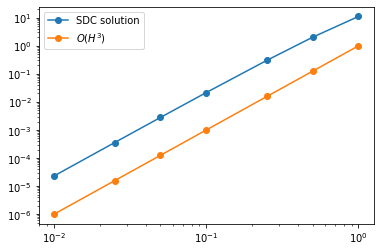

In [26]:
t0 = 0
tmax = 5
x0 = 1

H_coarse = np.array([0.01, 0.025, 0.05, 0.1, 0.25, 0.5, 1.])
L = len (H_coarse)
error = np.empty(L, float)
    
for n in range(L):
    grid_coarse, solution = sdc(x0, t0, tmax, H_coarse[n], 3, dahlquist)
    error[n] = abs(solution[len(solution)-1] - exact_solution(x0, 1, tmax))
        
plt.loglog(H_coarse, error,'o-')
plt.loglog(H_coarse, H_coarse**3,'o-')
plt.legend(['SDC solution', '$O(H^3)$'])
plt.show()




## Exercise
1. See this paper for the pseudocode for RIDC: https://mathgeek.us/research/papers/ridc.pdf Can you amend your code to implement this method?